In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [8]:
BATCH_SIZE = 256 #16 * tpu_strategy.num_replicas_in_sync

In [9]:
vanilla_df=pd.read_csv('../input/chestxray8-dataframe/train_df.csv').drop(['Image Index','Patient ID'],axis=1) #.drop_duplicates('Patient ID','last')
# if used drop duplicates then we can only work with those classes : Effusion,Infiltration, Mass, Nodule ,Atelectasis                                                        

In [10]:
vanilla_df.head()

,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


In [11]:
illness_df= vanilla_df[vanilla_df['No Finding'] !=1 ]
illness_df['Normal']=illness_df['No Finding']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
illness_df= illness_df[ illness_df['Hernia'] !=1]

In [13]:
illness_df= illness_df[ illness_df['Pneumonia'] !=1]

In [14]:
illness_df.describe()

,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,Normal
count,50020.000000,50020.000000,50020.000000,50020.0,50020.0,50020.000000,50020.000000,50020.000000,50020.000000,50020.000000,50020.000000,50020.0,50020.000000,50020.000000,50020.000000,50020.0
mean,0.054518,0.049660,0.259856,0.0,0.0,0.384526,0.113475,0.124710,0.224730,0.104818,0.066433,0.0,0.033267,0.039064,0.090644,0.0
std,0.227040,0.217244,0.438560,0.0,0.0,0.486488,0.317175,0.330393,0.417409,0.306322,0.249041,0.0,0.179334,0.193750,0.287105,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0


In [15]:
illness_df.sum()

Cardiomegaly                                                       2727
Emphysema                                                          2484
Effusion                                                          12998
No Finding                                                            0
Hernia                                                                0
Infiltration                                                      19234
Mass                                                               5676
Nodule                                                             6238
Atelectasis                                                       11241
Pneumothorax                                                       5243
Pleural_Thickening                                                 3323
Pneumonia                                                             0
Fibrosis                                                           1664
Edema                                                           

In [16]:
illness_df.drop(['No Finding','Hernia','Pneumonia'], inplace=True, axis=1)

In [17]:
vanilla_df.drop(['Hernia','Pneumonia'],axis=1,inplace=True)

In [18]:
illness_df.head()

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,FilePath,Normal
0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png,0
1,1,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png,0
2,1,0,1,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png,0
12,0,0,0,0,1,1,0,0,0,0,0,0,../input/data/images_001/images/00000004_000.png,0
19,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_006.png,0


In [19]:
vanilla_df['Normal']=vanilla_df['No Finding']
vanilla_df.drop( ['No Finding'] , axis=1 , inplace=True)

In [20]:
normal_df=vanilla_df[ vanilla_df['Normal'] ==1 ].loc[ 0:7200,:] # taking only 4000 images with normal conditions
normal_df

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,FilePath,Normal
3,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png,1
13,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_000.png,1
14,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_001.png,1
15,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_002.png,1
16,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_003.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_002/images/00001906_006.png,1
7196,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_002/images/00001906_007.png,1
7197,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_002/images/00001906_008.png,1
7198,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_002/images/00001907_000.png,1


In [21]:
effusion_df=vanilla_df[ vanilla_df['Effusion'] ==1 ].loc[ 0:40000,:] # taking only 4000 images with conditions
effusion_df

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,FilePath,Normal
2,1,0,1,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png,0
20,0,0,1,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_007.png,0
28,0,0,1,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000011_000.png,0
37,0,0,1,0,1,0,0,0,0,0,0,0,../input/data/images_001/images/00000012_000.png,0
42,0,1,1,1,0,0,0,1,0,0,0,0,../input/data/images_001/images/00000013_004.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39985,0,0,1,0,0,0,0,0,0,0,0,0,../input/data/images_005/images/00010475_021.png,0
39987,0,0,1,0,0,0,0,0,0,0,0,0,../input/data/images_005/images/00010475_023.png,0
39988,0,0,1,0,0,0,1,0,0,0,0,0,../input/data/images_005/images/00010475_024.png,0
39989,0,0,1,1,0,0,1,0,0,0,0,0,../input/data/images_005/images/00010475_025.png,0


In [22]:
infiltration_df=vanilla_df[ vanilla_df['Infiltration'] ==1 ].loc[ 0:22000,:] # taking only 3200 images with conditions
infiltration_df

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,FilePath,Normal
7,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_003.png,0
19,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_006.png,0
20,0,0,1,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000005_007.png,0
27,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000010_000.png,0
33,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000011_005.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21967,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_003/images/00005832_036.png,0
21968,0,0,0,1,0,0,0,0,0,0,0,0,../input/data/images_003/images/00005832_037.png,0
21969,0,0,1,1,0,0,0,0,0,0,0,1,../input/data/images_003/images/00005832_038.png,0
21970,0,0,1,1,0,0,0,0,0,0,0,1,../input/data/images_003/images/00005832_039.png,0


In [23]:
atelectasis_df=vanilla_df[ vanilla_df['Atelectasis'] ==1 ].loc[ 0:33000,:] # taking only 3100 images with normal conditions
atelectasis_df

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,FilePath,Normal
34,0,0,0,0,0,0,1,0,0,0,0,0,../input/data/images_001/images/00000011_006.png,0
68,1,1,0,0,1,0,1,1,0,0,0,0,../input/data/images_001/images/00000013_030.png,0
73,0,0,0,0,0,0,1,1,0,0,0,0,../input/data/images_001/images/00000013_035.png,0
92,0,0,1,0,0,0,1,0,1,0,0,0,../input/data/images_001/images/00000019_000.png,0
111,0,0,0,0,0,0,1,0,0,0,0,0,../input/data/images_001/images/00000030_000.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32917,0,0,0,0,0,0,1,0,0,0,1,0,../input/data/images_004/images/00008649_011.png,0
32919,0,0,1,0,0,0,1,0,0,0,0,0,../input/data/images_004/images/00008649_013.png,0
32946,0,0,0,0,0,0,1,0,0,0,0,1,../input/data/images_004/images/00008665_000.png,0
32982,0,0,1,0,0,0,1,0,0,0,0,0,../input/data/images_004/images/00008678_004.png,0


In [24]:
illness_df.sum()

Cardiomegaly                                                       2727
Emphysema                                                          2484
Effusion                                                          12998
Infiltration                                                      19234
Mass                                                               5676
Nodule                                                             6238
Atelectasis                                                       11241
Pneumothorax                                                       5243
Pleural_Thickening                                                 3323
Fibrosis                                                           1664
Edema                                                              1954
Consolidation                                                      4534
FilePath              ../input/data/images_001/images/00000001_000.p...
Normal                                                          

In [25]:
illness_df.drop(index= illness_df[illness_df['Effusion']==1].index , axis=0, inplace=True)

In [26]:
illness_df.sum()

Cardiomegaly                                                       1688
Emphysema                                                          2127
Effusion                                                              0
Infiltration                                                      15365
Mass                                                               4448
Nodule                                                             5341
Atelectasis                                                        8042
Pneumothorax                                                       4263
Pleural_Thickening                                                 2492
Fibrosis                                                           1480
Edema                                                              1428
Consolidation                                                      3276
FilePath              ../input/data/images_001/images/00000001_000.p...
Normal                                                          

## thats what we want now, to remove the excess rows


In [27]:
illness_df.drop(index= illness_df[illness_df['Infiltration']==1].index , axis=0, inplace=True)
illness_df.drop(index= illness_df[illness_df['Atelectasis']==1].index , axis=0, inplace=True)

In [28]:
illness_df.sum()

Cardiomegaly                                                       1279
Emphysema                                                          1542
Effusion                                                              0
Infiltration                                                          0
Mass                                                               3335
Nodule                                                             3819
Atelectasis                                                           0
Pneumothorax                                                       3159
Pleural_Thickening                                                 1813
Fibrosis                                                           1036
Edema                                                               814
Consolidation                                                      1926
FilePath              ../input/data/images_001/images/00000001_000.p...
Normal                                                          

In [29]:
balanced_df= illness_df.append([normal_df,atelectasis_df,infiltration_df,effusion_df])
path=balanced_df['FilePath']
balanced_df.head()

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,FilePath,Normal
0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png,0
1,1,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png,0
12,0,0,0,0,1,1,0,0,0,0,0,0,../input/data/images_001/images/00000004_000.png,0
23,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000008_000.png,0
25,0,0,0,0,0,1,0,0,0,0,0,0,../input/data/images_001/images/00000008_002.png,0


In [30]:
balanced_df.describe()

,Cardiomegaly,Emphysema,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Fibrosis,Edema,Consolidation,Normal
count,30094.000000,30094.000000,30094.000000,30094.000000,30094.000000,30094.000000,30094.000000,30094.00000,30094.000000,30094.000000,30094.000000,30094.000000,30094.000000
mean,0.061673,0.059746,0.177444,0.171629,0.130524,0.147637,0.153320,0.12245,0.076627,0.042367,0.038347,0.091081,0.134844
std,0.240565,0.237020,0.382050,0.377064,0.336885,0.354746,0.360301,0.32781,0.266002,0.201429,0.192035,0.287729,0.341563
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
col= ['Cardiomegaly','Emphysema','Effusion','Infiltration',
      'Mass','Nodule','Atelectasis','Pneumothorax',
      'Pleural_Thickening','Fibrosis','Edema','Consolidation','Normal']

In [32]:
balanced_df.sum()

Cardiomegaly                                                       1856
Emphysema                                                          1798
Effusion                                                           5340
Infiltration                                                       5165
Mass                                                               3928
Nodule                                                             4443
Atelectasis                                                        4614
Pneumothorax                                                       3685
Pleural_Thickening                                                 2306
Fibrosis                                                           1275
Edema                                                              1154
Consolidation                                                      2741
FilePath              ../input/data/images_001/images/00000001_000.p...
Normal                                                          

In [33]:
balanced_df.drop_duplicates('FilePath', inplace=True)

In [34]:
balanced_df.sum()

Cardiomegaly                                                       1732
Emphysema                                                          1761
Effusion                                                           4010
Infiltration                                                       4009
Mass                                                               3818
Nodule                                                             4343
Atelectasis                                                        3356
Pneumothorax                                                       3597
Pleural_Thickening                                                 2210
Fibrosis                                                           1245
Edema                                                              1092
Consolidation                                                      2584
FilePath              ../input/data/images_001/images/00000001_000.p...
Normal                                                          

## Great now that our dataset is kind of balanced, we can proceed

In [35]:
balanced_df= balanced_df.sample(frac=1)

In [36]:
tmp_gen= tf.keras.preprocessing.image.ImageDataGenerator(
                                                            samplewise_center=True,
                                                            samplewise_std_normalization=True,
                                                            rotation_range=0.2,
                                                            zca_whitening=True,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            zoom_range=0.15,
                                                            horizontal_flip=True,
                                                            rescale=1/255.,
                                                            validation_split=0.2)


train_data= tmp_gen.flow_from_dataframe(  dataframe= balanced_df ,
                                          directory= None ,
                                          x_col='FilePath' ,
                                          y_col= col ,
                                          class_mode="raw" ,
                                          batch_size= BATCH_SIZE ,
                                          shuffle= True ,
                                          target_size= (224,224),
                                          subset="training"
                                       )

val_data= tmp_gen.flow_from_dataframe(  dataframe= balanced_df ,
                                         directory= None ,
                                         x_col= 'FilePath' ,
                                         y_col= col ,
                                         class_mode= "raw" ,
                                         batch_size= BATCH_SIZE ,
                                         shuffle= True ,
                                         target_size= (224,224),
                                         subset= 'validation'
                                      )

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 22731 validated image filenames.
Found 5682 validated image filenames.


In [37]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Adagrad
import seaborn as sns

In [38]:
# creating index to class dictionary
idx_class={i:c for i,c in enumerate(col)}

In [39]:
def get_CAM(processed_image, actual_label, layer_name='conv2d_127'):
    model_grad = Model( [model.inputs] ,   [model.get_layer(layer_name).output , model.output]  )
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        # get prediction probability of dog
        # If model does well, 
        # pred_prob should be close to 0 if cat, close to 1 if dog
        pred_prob = predictions[:,1] # [ batch , (cat_prob , dog_prob) ]
        # we tale only one prbability to be able to use binary_crossentropy_loss not sparse_categorical_loss
        
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast( actual_label , dtype=tf.float32 )
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        # we can use tf.keras in that too
        # bce = tf.keras.losses.BinaryCrossentropy()
        # bce(y_true, y_pred).numpy()


        loss = -1 * ( actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing) )
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss , conv_output_values)
    grads_values = tf.keras.backend.mean(grads_values , axis=(0,1,2)) # mean over batch , hight , width --> num of channels
    
    conv_output_values = np.squeeze( conv_output_values.numpy() ) # will remove the 1 valued dimention which is the batch  --> (h , w )
    grads_values = grads_values.numpy()
    print(conv_output_values.shape)
    # weight the convolution outputs with the computed gradients
    for i in range(128): # num of filter channels
        conv_output_values[ : , : , i ] *= grads_values[i] # multiply the gradient of the channels by the channels values
    heatmap = np.mean(conv_output_values, axis=-1)# taking the mean over the channels , --> ( h , w )
    
    heatmap = np.maximum(heatmap, 0) # taking only the positive values
    heatmap /= heatmap.max()# regularizing the pixel values
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [40]:
def show_sample():
    

    images, labels= next(val_data)
    sample_image = images[0]  # batch 0 so that returns ( h , w , c) for the image, without the batch dimention
    sample_label = labels[0] # takes batch of xs and ys # x= train_data.next() -> x[0].shape -> 32,224,224,3
    
    sample_image_processed = np.expand_dims(sample_image, axis=0) # adding back the batch dimention
    
    activations = vis_model.predict(sample_image_processed) # the output of each layer -features-
    
    pred_label = np.argmax( model.predict(sample_image_processed) , axis=-1 )[0]
    pred_label = idx_class[pred_label]
    
    print(activations[0].shape)
    sample_activation = activations[0] [0 , : , : , -1] # taking the first output , for image of batch 0, and for the last layer #16 , --> (h,w)
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip( sample_activation , 0 , 255 ).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed , sample_label )
    heatmap = cv2.resize( heatmap, ( sample_image.shape[0], sample_image.shape[1 ]) )
    heatmap = heatmap *255
    heatmap = np.clip( heatmap , 0 , 255 ).astype(np.uint8)
    heatmap = cv2.applyColorMap( heatmap , cv2.COLORMAP_HOT )
    converted_img = sample_image
    super_imposed_image = cv2.addWeighted( converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0 )
    
    sample_label = idx_class[np.argmax(sample_label)]
    
    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

## As we can see i'm only refining the last layer only, 14k params to train

In [ ]:
def build_model():
  # load the base VGG16 model
  base_model = load_model('../input/chet-xray-encoder-model/encoder_model.h5')
  
  # build on top of AE
  #output = layers.GlobalAveragePooling2D()(base_model.output)
  output=layers.Flatten()(base_model.output)
  output = layers.BatchNormalization()(output)
  output = layers.Dense(64, activation='relu')(output)
  output = layers.Dropout(0.4)(output)
#   output = layers.Dense(32, activation='relu')(output)
#   output = layers.BatchNormalization()(output)
  output = layers.Dense( len(col) , activation='sigmoid')(output)

  # set the inputs and outputs of the model
  model = Model( base_model.input , output )

  # freeze the earlier layers and leave the last 4 layers to train
    
  for layer in base_model.layers[:]:
       layer.trainable=False

  # choose the optimizer
  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  # configure the model for training

  model.compile(loss='binary_crossentropy', 
                optimizer= 'adam',#RMSprop( 0.001 , momentum=0.98 ), #Adam(0.004 ), #Adadelta(),
                metrics=[tf.keras.metrics.AUC()])
  
  # display the summary
  model.summary()
  
  return model

model=build_model()

# ***let's Plot the outputs before model training***

Layers that will be used for visualization: 
['conv2d_122', 'conv2d_123', 'max_pooling2d_30', 'conv2d_124', 'conv2d_125', 'max_pooling2d_31', 'conv2d_126', 'max_pooling2d_32', 'conv2d_127', 'conv2d_128', 'flatten', 'batch_normalization', 'dense', 'dropout', 'dense_1']


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(1, 224, 224, 32)
binary loss: [0.03808235 0.03808235 0.03808235 3.2864497  0.03808235 0.03808235
 0.03808235 0.03808235 0.03808235 0.03808235 0.03808235 3.2864497
 0.03808235]
(28, 28, 1024)


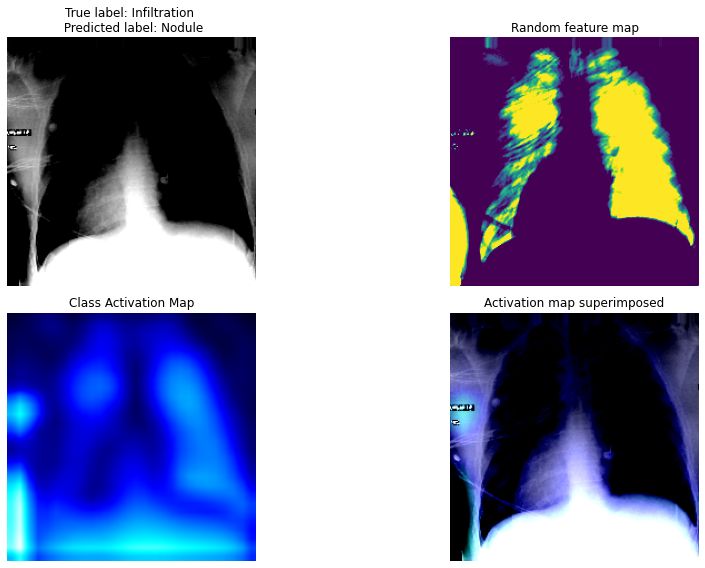

In [44]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [ layer.output for layer in model.layers[1:] ] # all layers except the input layer

# Define a new model that generates the above output
vis_model = Model(model.input , outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append( layer.name.split("/")[0] )

    
print("Layers that will be used for visualization: ")
print(layer_names)
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample()

# Training the model

In [43]:
# defining our call backs
cb= tf.keras.callbacks.ModelCheckpoint( "my_model.h5" , save_best_only=True  )

In [ ]:
history= model.fit( train_data , validation_data= val_data , 
                    epochs= 50 , callbacks= [cb] 
                  )

# Using a non completed training model to continue the training

In [112]:
# instantiating the model in the strategy scope creates the model on the TPU
model = load_model('../input/nih-13-pretrained-encoder/my_model.h5')


In [ ]:
history= model.fit( train_data , validation_data= val_data , 
                    epochs= 15 , callbacks= [cb] 
                  )

## Let's train all the layers to see an improvements


In [52]:
for l in model.layers :
    l.trainable= True

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 256)       0     

In [55]:
history= model.fit( train_data , validation_data= val_data , 
                    epochs= 15 , callbacks= [cb] 
                  )

Epoch 1/15
89/89 [==============================] - 1061s 12s/step - loss: 0.3130 - auc: 0.6761 - val_loss: 0.3051 - val_auc: 0.6972
Epoch 2/15
89/89 [==============================] - 1074s 12s/step - loss: 0.3126 - auc: 0.6774 - val_loss: 0.3056 - val_auc: 0.6953
Epoch 3/15
89/89 [==============================] - 1020s 11s/step - loss: 0.3124 - auc: 0.6778 - val_loss: 0.3051 - val_auc: 0.6975
Epoch 4/15
89/89 [==============================] - 1012s 11s/step - loss: 0.3124 - auc: 0.6774 - val_loss: 0.3054 - val_auc: 0.6963
Epoch 5/15
89/89 [==============================] - 1014s 11s/step - loss: 0.3124 - auc: 0.6778 - val_loss: 0.3053 - val_auc: 0.6963
Epoch 6/15
89/89 [==============================] - 1049s 12s/step - loss: 0.3120 - auc: 0.6801 - val_loss: 0.3049 - val_auc: 0.6976
Epoch 7/15
89/89 [==============================] - 1066s 12s/step - loss: 0.3124 - auc: 0.6783 - val_loss: 0.3048 - val_auc: 0.6979
Epoch 8/15
89/89 [==============================] - 1011s 11s/step - 

KeyboardInterrupt: 

# Plotting after returning to train back and forth, which will show nothing useful 

(0.0, 1.0)

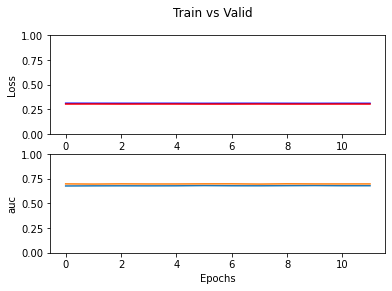

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.suptitle('Train vs Valid')

ax1.plot(range(12), model.history.history['loss'],color='b', label='loss')
ax1.plot(range(12), model.history.history['val_loss'],color='r', label='val_loss')
ax1.set_ylabel('Loss')


ax2.plot(range(12), model.history.history['auc'], label='auc')
ax2.plot(range(12), model.history.history['val_auc'], label='val_auc')
ax2.set_ylabel('auc')

ax2.set_xlabel('Epochs')


ax2.set_ylim([0,1])
ax1.set_ylim([0,1])

Layers that will be used for visualization: 
['conv2d_122', 'conv2d_123', 'max_pooling2d_30', 'conv2d_124', 'conv2d_125', 'max_pooling2d_31', 'conv2d_126', 'max_pooling2d_32', 'conv2d_127', 'conv2d_128', 'flatten', 'batch_normalization', 'dense', 'dropout', 'dense_1']


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(1, 224, 224, 32)
binary loss: [0.06996622 0.06996622 0.06996622 0.06996622 0.06996622 0.06996622
 2.694226   0.06996622 0.06996622 0.06996622 0.06996622 0.06996622
 0.06996622]
(28, 28, 1024)


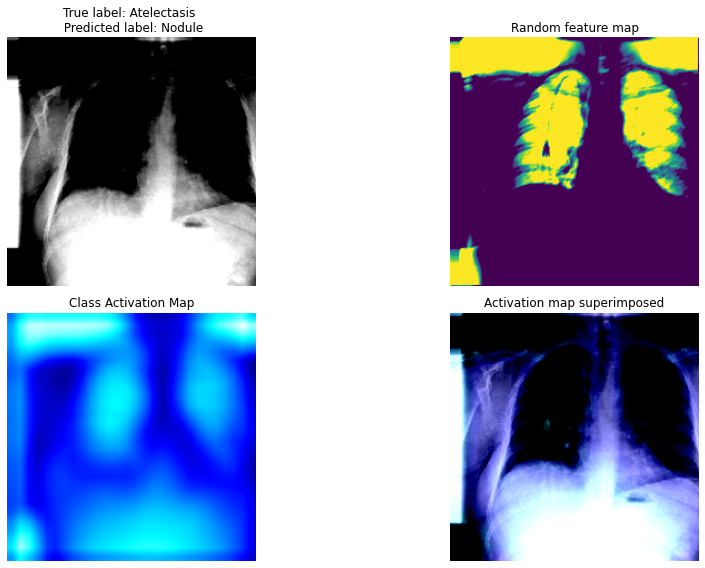

In [59]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [ layer.output for layer in model.layers[1:] ] # all layers except the input layer

# Define a new model that generates the above output
vis_model = Model(model.input , outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append( layer.name.split("/")[0] )

    
print("Layers that will be used for visualization: ")
print(layer_names)
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample()

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[[ 0  0  5  2  0  1  3  3  0  0  0  0  0]
 [ 0  0  3  1  0  2  1  3  0  0  0  0  1]
 [ 0  0 10  8  1 11  4  4  0  0  0  2  1]
 [ 0  0  2  4  0 10  6  2  0  0  0  0  2]
 [ 0  0  1  2  0 19  0  4  0  0  0  0  2]
 [ 0  0  3  0  1 12  1  5  0  0  0  1  4]
 [ 0  0  3  0  1  3  5  0  0  0  0  0  2]
 [ 0  0  0  3  2 10  0  6  0  0  0  0  0]
 [ 0  0  2  1  1  5  0  1  0  0  0  1  0]
 [ 0  0  1  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  1  1  1  0  0  1  0  0  1  0  0]
 [ 0  0  0  2  0  4  1  4  0  0  2  0  0]
 [ 0  0  5  0  1 22  1  7  0  0  0  0  5]]


<AxesSubplot:>

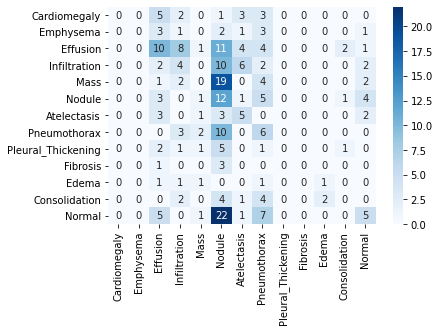

In [58]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import sklearn
test_generator= val_data.next()
y_predict =np.argmax( model.predict(test_generator[0]),axis=1)

#tn, fp, fn, tp = np.max( confusion_matrix( test_generator.labels , y_predict ) , axis=1)
matrix=confusion_matrix(np.argmax(test_generator[1], axis=1) , y_predict)
print(matrix)
# Confusion matrix Plotting
import seaborn as sns
#classes=['covid', 'normal', 'pnumonia']
sns.heatmap(matrix, annot=True, xticklabels=col, yticklabels=col ,cmap='Blues')#YlGnBu_r or Blues or twilight_shifted_r

Class is:  Emphysema


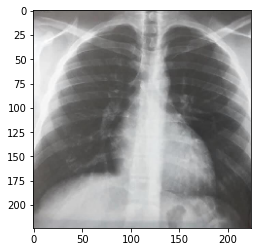

In [79]:
from tensorflow.keras.preprocessing import image
#2- setting the path of the image
path='../input/nawwar/1.jpeg'
#3- uploading the image into a variable

img= image.load_img( path , target_size=( 224,224 ) )
# don't forget the target size the model is expecting
#4- processing the image variable to suit the model

x= image.img_to_array( img )
x= np.expand_dims( x , axis=0 )
images= np.vstack( [x] )

plt.imshow(img) # to show the image
# to predict the image
print('Class is: ', idx_class[np.argmax(model.predict(x))] )

In [110]:
def classify(image):
    
    sample_image = image  # batch 0 so that returns ( h , w , c) for the image, without the batch dimention
    #sample_label = label # takes batch of xs and ys # x= train_data.next() -> x[0].shape -> 32,224,224,3
    
    sample_image_processed = np.expand_dims(sample_image, axis=0) # adding back the batch dimention
    
    activations = vis_model.predict(sample_image_processed) # the output of each layer -features-
    
    pred_label = np.argmax( model.predict(sample_image_processed) , axis=-1 )[0]
    pred_label = idx_class[pred_label]
    
    print(activations[0].shape)
    sample_activation = activations[0] [0 , : , : , :3] # taking the first output , for image of batch 0, and for the last layer #16 , --> (h,w)
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip( sample_activation , 0 , 255 ).astype(np.uint8)
    
    f,ax = plt.subplots(1,2, figsize=(15,8))

    ax[0].imshow(sample_image)
    ax[0].set_title(f"Predicted label: {pred_label}")
    ax[0].axis('off')
    
    ax[1].imshow(sample_activation)
    ax[1].set_title("Random feature map")
    ax[1].axis('off')
 
    plt.tight_layout()
    plt.show()
  
    return activations

(1, 224, 224, 32)


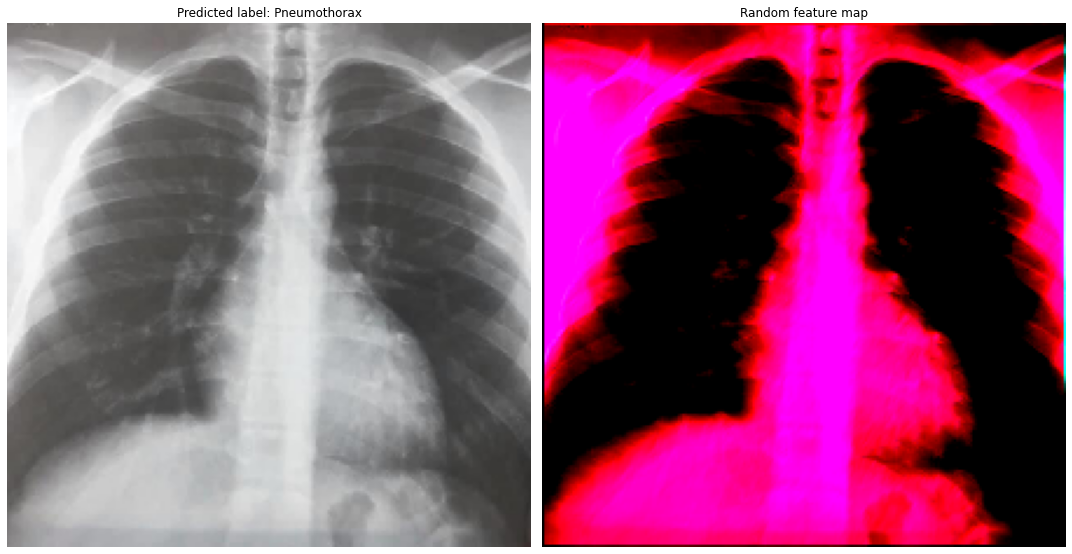

In [113]:
from tensorflow.keras.preprocessing import image
#2- setting the path of the image
path='../input/nawwar/1.jpeg'
#3- uploading the image into a variable

img= image.load_img( path , target_size=( 224,224 ) )
# don't forget the target size the model is expecting
#4- processing the image variable to suit the model

x= image.img_to_array( img )

c=classify(img)